# MODELING

## PROBLEM DEFINITION AND GOALS

**We aim to model, predict, and simulate foreign aid dynamics for Kenya.**  

### CORE MODELING OBJECTIVES

1. **Aid Flow Stability And Volatility Analysis**  
   - Goal: Identify which sectors, agencies, and partners are most stable, volatile, or dominant in aid delivery.  
   - Approach:  
     - Compute volatility metrics (rolling std, coefficient of variation).  
     - Classify entities using unsupervised clustering or ranking.  
     - Highlight dominant vs. emerging actors.

2. **Predictive And Scenario Forecasting**  
   - Goal: Predict future funding flows or simulate policy shocks (e.g., “25% cut in USAID funding”).  
   - Approach: 
     - Use regression models (XGBoost, Random Forest, Prophet) on aid totals.  
     - Simulate counterfactual scenarios by adjusting model inputs.

3. **Temporal Forecasting And Shock Simulation**  
   - Goal: Model aid trends across fiscal years and assess resilience to fiscal shocks.  
   - Approach:  
     - Time series forecasting (Prophet, ARIMA, LSTM).  
     - Introduce synthetic shocks to test system response.

4. **Sectoral Dependency Clustering**  
   - Goal: Cluster sectors by their dependency on foreign aid.  
   - Approach:  
     - Use KMeans, DBSCAN, or hierarchical clustering.  
     - Base features on aid ratios and concentration metrics.

## DATA AUDIT

### STRONG COLUMNS
Provide robust quantitative and categorical anchors:
- Temporal: fiscal_year, transaction_date, year, quarter
- Categorical Context: country_name, us_sector_name, us_category_name
- Management Context: managing_subagency_or_bureau_name, funded_and_managed_by, dominant_sector_per_agency
- Monetary & Variability Indicators:  
  current_dollar_amount, constant_dollar_amount, total_aid_fiscal,  
  aid_volatility, rolling_mean_3yr, rolling_std_3yr, aid_concentration_index,  
  top3_agency_share, sector_to_total_ratio, agency_to_total_ratio,  
  aid_per_partner, relative_aid_share, aid_std_fiscal,  
  mean_aid_per_transaction_fiscal

### COLUMNS THAT NEED ATTENTION
- objective, transaction_type_name -> will need grouping or encoding.  
- transaction_lag, transaction_lead -> align correctly with fiscal years.    

### COLUMNS TO DROP
- transaction_date -> replace with derived temporal features.  
- country_name -> constant for Kenya, can be dropped.  
- Columns ending in _interaction -> use dimensionality reduction (PCA) or selective inclusion.

## WORKFLOW

### DATA PREPARATION
1. Handle missingness with appropriate imputations.  
2. Normalize skewed monetary variables (we will use log1p).  
3. Encode categorical variables using **target encoding** or **frequency encoding**.  
4. Aggregate aid data by **year**, **sector**, or **agency** depending on the model goal.  
5. Split data chronologically (e.g train up to 2019, test from 2020 onward).

### FEATURE ENGINEERING CONSIDERATIONS
- Rolling averages: rolling_mean_3yr, rolling_std_3yr, sector_growth_rate, agency_growth_rate
- Concentration & diversity: aid_concentration_index, aid_diversity_index
- Ratios: sector_to_total_ratio, agency_to_total_ratio
- Interaction terms: agency_sector_interaction, partner_agency_interaction

### TARGET PICKING

| Objective | Problem Type | Model Candidates | Key Targets |
|------------|---------------|------------------|--------------|
| **Stability & Volatility** | Unsupervised / Ranking | KMeans, Isolation Forest, PCA, TS Clustering | aid_volatility, aid_concentration_index |
| **Predictive Forecasting** | Supervised Regression | XGBoost, LightGBM, Prophet | total_aid_fiscal, constant_dollar_amount |
| **Temporal Forecasting** | Time Series | Prophet, ARIMA, LSTM | total_aid_fiscal, sector_to_total_ratio |
| **Sector Dependency** | Clustering | KMeans, Spectral, DBSCAN | sector_to_total_ratio, aid_per_partner, aid_concentration_index |

### EVALUATION METRICS
- **Regression Models:** RMSE, MAE, MAPE, R²  
- **Forecasting Models:** MAPE, RMSE, Directional Accuracy  
- **Clustering Models:** Silhouette Score, Calinski-Harabasz Index  
- **Volatility Analysis:** Rolling std comparison, stability ranking

### SCENARIO SIMULATION
Run post-model scenario experiments:
- Introduce a **shock factor**, e.g., USAID_cut = -0.25  
- Recompute predicted totals and compare to baseline.  
- Measure cascading impacts by sector (sector_to_total_ratio shifts).  
- Visualize using waterfall charts or delta bar plots.

### VISUALS
- **Time Series:** Aid trends per sector/agency.  
- **Heatmaps:** Volatility or concentration over time.  
- **Cluster Maps:** Sector dependency visualization.  
- **Scenario Dashboards:** Policy or funding cut simulations.

In [86]:
# ------- [Import all relevant libraries] -------

# General Utilities
import warnings
warnings.filterwarnings('ignore')

import numpy as np                          # Numerical computing
import pandas as pd                         # Data manipulation and analysis
import datetime as dt                       # Date/time operations
import re                                   # String manipulation
from collections import Counter             # Frequency counting
import logging
import math
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Statistics
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Feature Engineering & Preprocessing
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler,
    RobustScaler
)
from sklearn.model_selection import (
    train_test_split, TimeSeriesSplit, GridSearchCV, StratifiedKFold
)
from sklearn.decomposition import PCA, TruncatedSVD

# Machine Learning Models
# ======================

## Supervised Learning (Regression/Prediction)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

## Unsupervised Learning (Volatility and Dependency Clustering)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

## Time Series & Forecasting
from statsmodels.tsa.arima.model import ARIMA
# !pip install prophet
from prophet import Prophet

# Evaluation Metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    silhouette_score, calinski_harabasz_score,
    davies_bouldin_score
)

# # Imbalanced Data Handling
# from imblearn.over_sampling import SMOTE

# Model Interpretation & Explainability
# !pip install eli5
from lime import lime_tabular

# Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
from IPython.display import display

In [87]:
# Load data
df = pd.read_csv("../Clean Data/clean_data.csv")

# Drop country_name since we know this is Kenyan data alone
df.drop(columns=['country_name'], inplace=True)

# ------- [Quick Data Understanding] -------

# Check the shape
print(f"\nDataset shape: {df.shape[0]} rows and {df.shape[1]} columns.")

# Check column names
print("\n"+'**'*42+'\n')
print("Columns:\n", df.columns)

# Metadata check
print("\n"+'**'*42+'\n')
print("Metadata:\n")
df.info()


Dataset shape: 68235 rows and 51 columns.

************************************************************************************

Columns:
 Index(['managing_subagency_or_bureau_name', 'us_category_name',
       'us_sector_name', 'objective', 'transaction_type_name', 'fiscal_year',
       'transaction_date', 'current_dollar_amount', 'constant_dollar_amount',
       'transaction_year', 'transaction_month', 'transaction_quarter',
       'is_end_of_fiscal_year', 'days_since_start_of_year',
       'is_holiday_quarter', 'aid_volatility', 'rolling_mean_3yr',
       'rolling_std_3yr', 'total_aid_fiscal', 'transaction_count_fiscal',
       'mean_aid_per_transaction_fiscal', 'aid_std_fiscal', 'total_sector_aid',
       'avg_sector_aid', 'sector_transaction_count', 'total_agency_aid',
       'avg_agency_aid', 'agency_transaction_count', 'total_partner_aid',
       'partner_transaction_count', 'sector_to_total_ratio',
       'agency_to_total_ratio', 'transaction_lag', 'transaction_lead',
       's

In [88]:
# ------- [Data Quality Checks] -------

# Duplicates
print("Duplicates:", df.duplicated().sum())

# Missing Values
print("\nMissing Values:\n", df.isna().sum())

Duplicates: 0

Missing Values:
 managing_subagency_or_bureau_name    0
us_category_name                     0
us_sector_name                       0
objective                            0
transaction_type_name                0
fiscal_year                          0
transaction_date                     0
current_dollar_amount                0
constant_dollar_amount               0
transaction_year                     0
transaction_month                    0
transaction_quarter                  0
is_end_of_fiscal_year                0
days_since_start_of_year             0
is_holiday_quarter                   0
aid_volatility                       0
rolling_mean_3yr                     0
rolling_std_3yr                      0
total_aid_fiscal                     0
transaction_count_fiscal             0
mean_aid_per_transaction_fiscal      0
aid_std_fiscal                       0
total_sector_aid                     0
avg_sector_aid                       0
sector_transaction_count        

In [121]:
df[['fiscal_year', 'transaction_date']]

,fiscal_year,transaction_date
0,2024,2024-09-02
1,2021,2021-06-30
2,2022,2022-06-30
3,2023,2022-12-31
4,2023,2023-03-31
...,...,...
68230,2021,2021-07-31
68231,2021,2021-08-31
68232,2021,2021-09-30
68233,2025,2024-11-01


## DESCRIPTIVE ANALYTICS FOR FEATURE SELECTION

Strong Pearson Correlations (|r| > 0.7):


,Feature 1,Feature 2,Correlation
258,aid_std_fiscal,aid_volatility,1.000000
1,current_dollar_amount,constant_dollar_amount,0.997202
30,current_dollar_amount,aid_per_transaction_ratio,0.988428
991,aid_per_transaction_ratio,relative_aid_share,0.987092
31,current_dollar_amount,relative_aid_share,0.983363
63,constant_dollar_amount,relative_aid_share,0.979736
961,aid_per_transaction_ratio,constant_dollar_amount,0.977754
305,total_sector_aid,sector_to_total_ratio,0.961812
802,aid_concentration_index,aid_volatility,0.952481
281,aid_std_fiscal,aid_concentration_index,0.952481


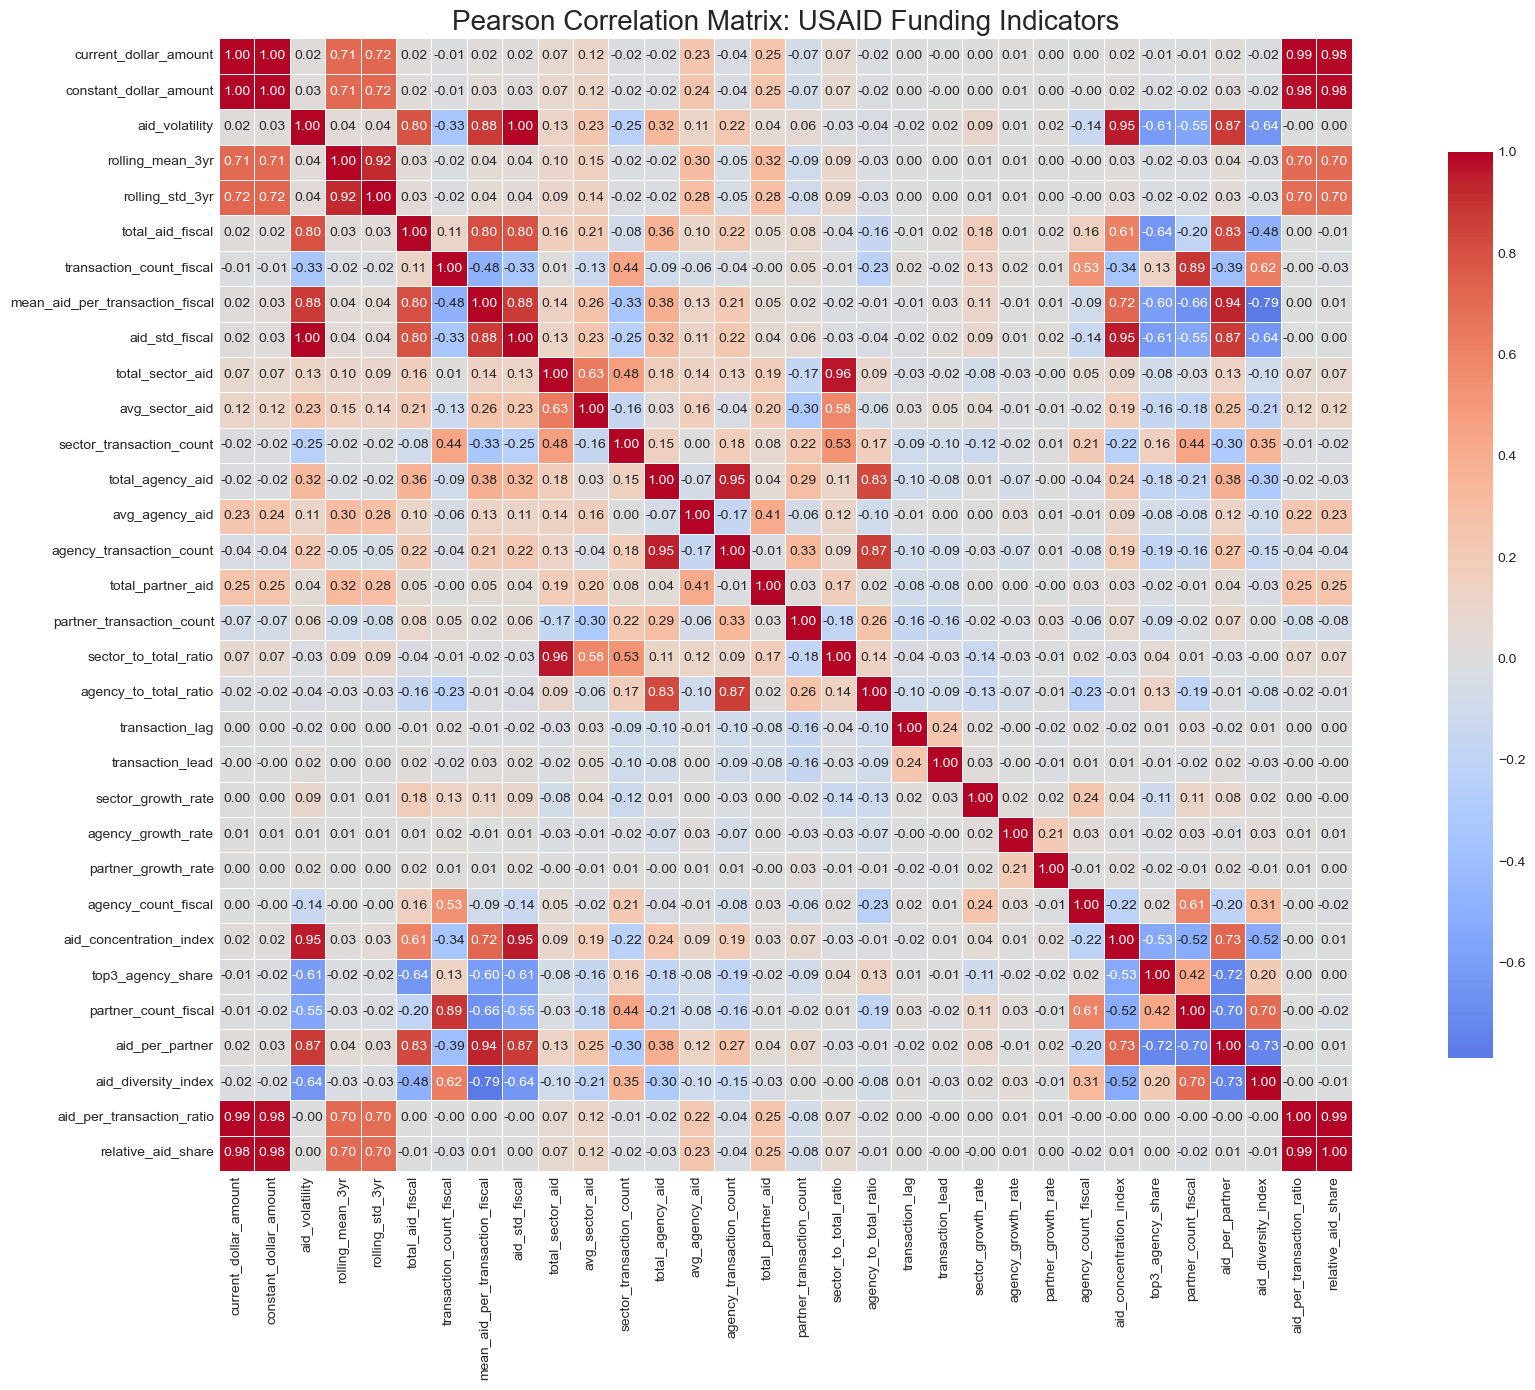

In [89]:
num_cols = [
    'current_dollar_amount', 'constant_dollar_amount', 
    'aid_volatility', 'rolling_mean_3yr', 'rolling_std_3yr',
    'total_aid_fiscal', 'transaction_count_fiscal', 
    'mean_aid_per_transaction_fiscal', 'aid_std_fiscal',
    'total_sector_aid', 'avg_sector_aid', 'sector_transaction_count',
    'total_agency_aid', 'avg_agency_aid', 'agency_transaction_count',
    'total_partner_aid', 'partner_transaction_count',
    'sector_to_total_ratio', 'agency_to_total_ratio',
    'transaction_lag', 'transaction_lead',
    'sector_growth_rate', 'agency_growth_rate', 'partner_growth_rate',
    'agency_count_fiscal', 'aid_concentration_index', 'top3_agency_share',
    'partner_count_fiscal', 'aid_per_partner', 
    'aid_diversity_index', 'aid_per_transaction_ratio',
    'relative_aid_share'
]

# Compute correlation matrix
corr = df[num_cols].corr(method='pearson')

# Flatten and filter
corr_pairs = corr.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_pairs = corr_pairs[(corr_pairs['Feature 1'] != corr_pairs['Feature 2'])]  # remove self-correlations
strong_corrs = corr_pairs[corr_pairs['Correlation'].abs() > 0.7].sort_values(by='Correlation', ascending=False)

# Drop duplicates (A,B) and (B,A)
strong_corrs = strong_corrs[
    strong_corrs.apply(lambda x: tuple(sorted([x['Feature 1'], 
                                               x['Feature 2']])), axis=1).duplicated() == False
]

# Display top correlations as a dataframe
print("Strong Pearson Correlations (|r| > 0.7):")
display(strong_corrs.head(30))

# Visualize
plt.figure(figsize=(20, 14))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt=".2f", 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Pearson Correlation Matrix: USAID Funding Indicators', fontsize=20)
plt.tight_layout()
plt.show()

Strong Spearman Correlations (|ρ| > 0.7):


,Feature 1,Feature 2,Correlation
258,aid_std_fiscal,aid_volatility,1.000000
1,current_dollar_amount,constant_dollar_amount,0.999338
30,current_dollar_amount,aid_per_transaction_ratio,0.998043
1022,relative_aid_share,aid_per_transaction_ratio,0.998001
31,current_dollar_amount,relative_aid_share,0.996944
63,constant_dollar_amount,relative_aid_share,0.995715
961,aid_per_transaction_ratio,constant_dollar_amount,0.995625
553,sector_to_total_ratio,total_sector_aid,0.972378
284,aid_std_fiscal,aid_per_partner,0.970621
92,aid_volatility,aid_per_partner,0.970621


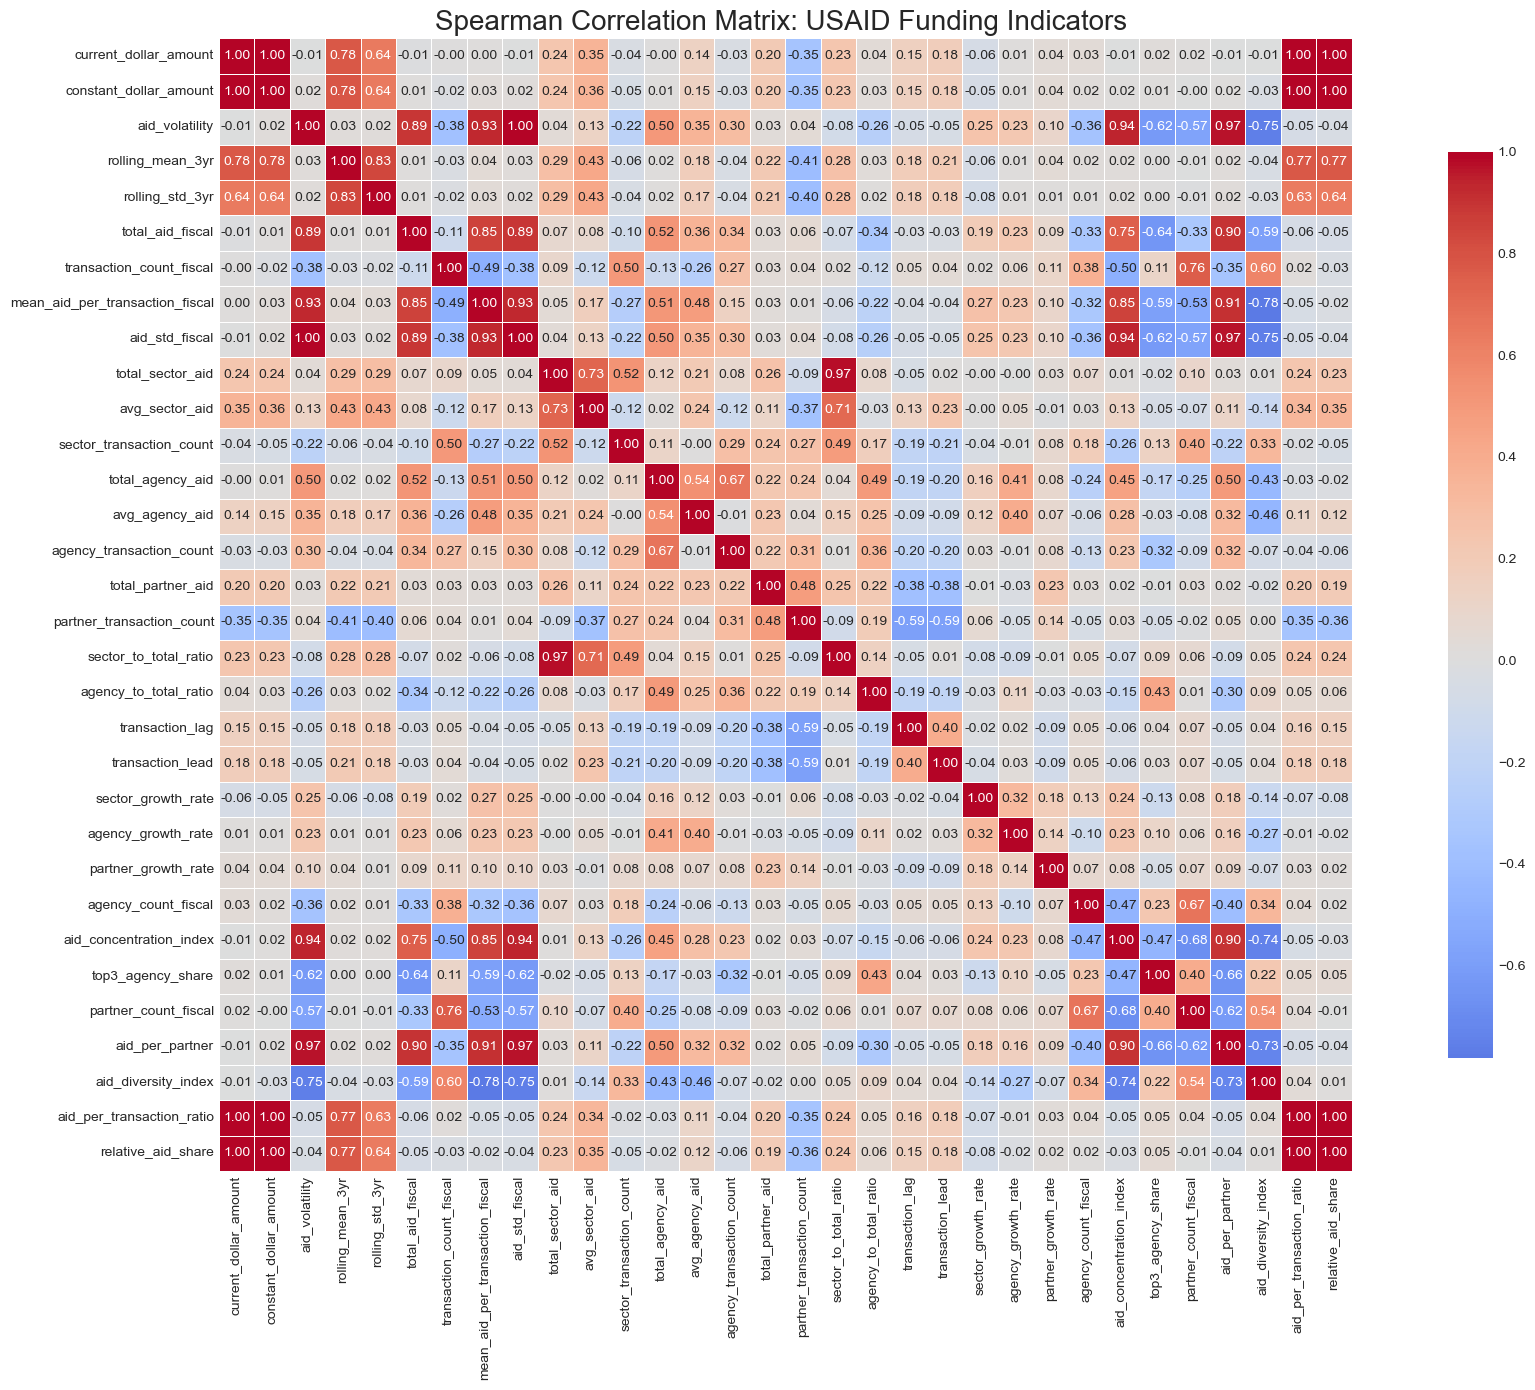

In [90]:
corr_spearman = df[num_cols].corr(method='spearman')

# Flatten, clean, and sort
corr_pairs = corr_spearman.unstack().reset_index()
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]

# Filter strong correlations
strong_corrs = corr_pairs[corr_pairs['Correlation'].abs() > 0.7].sort_values(by='Correlation', ascending=False)

# Drop duplicate (A,B) / (B,A) pairs
strong_corrs = strong_corrs[
    strong_corrs.apply(lambda x: tuple(sorted([x['Feature 1'], 
                                               x['Feature 2']])), axis=1).duplicated() == False
]

# Display strong correlations
print("Strong Spearman Correlations (|ρ| > 0.7):")
display(strong_corrs.head(30))

plt.figure(figsize=(20, 14))
sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=True, fmt=".2f", 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Spearman Correlation Matrix: USAID Funding Indicators ', fontsize=20)
plt.tight_layout()
plt.show()

## CLUSTERING

Uncovering relationships between sectors.

### 1. KMEANS

In [91]:
# Create a copy
model_df = df.copy(deep=True)

# Separate target and features
X = model_df.drop('us_sector_name', axis=1)
y = model_df['us_sector_name']

# Encode categorical columns
cat_cols = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True, dtype=int)

# Handle missing / infinite values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Scale numeric features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

MemoryError: Unable to allocate 2.40 GiB for an array with shape (4725, 68235) and data type int64

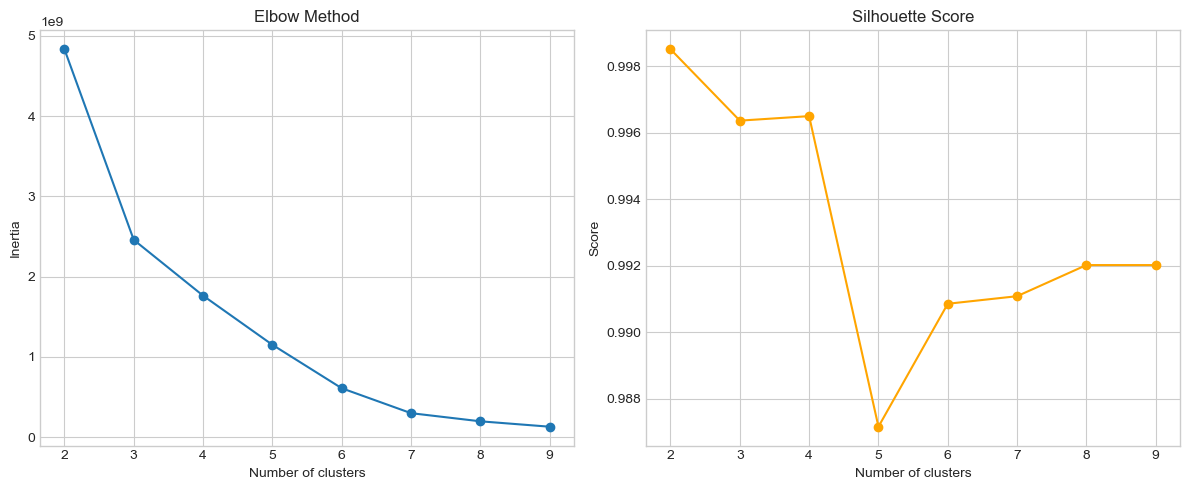

In [ ]:
# Dimensionality reduction
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Optimal cluster number (Elbow + Silhouette)
inertias = []
sil_scores = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_pca, km.labels_))

# Plot elbow & silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(K, inertias, 'o-', label='Inertia')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot(K, sil_scores, 'o-', color='orange', label='Silhouette')
ax[1].set_title('Silhouette Score')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Score')

plt.tight_layout()
plt.show()

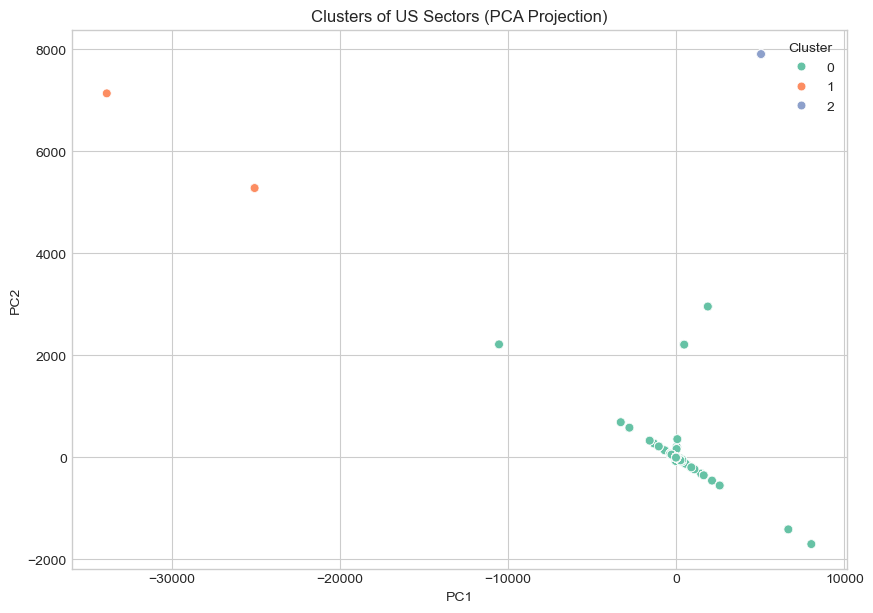

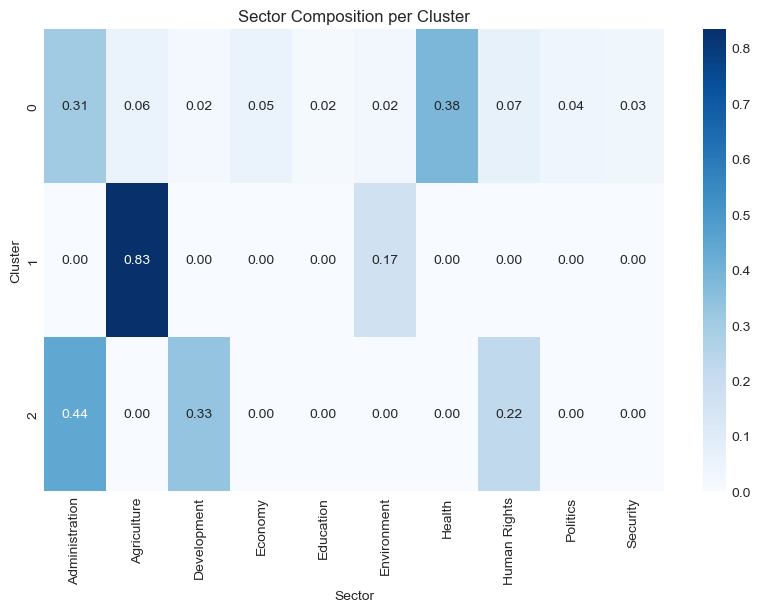

In [ ]:
# Fit final model 
optimal_k = 3  # from elbow plot above
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# Add clusters back to data
results = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
results['Cluster'] = cluster_labels
results['Sector'] = y.values

# Visualize clusters and sector mix
plt.figure(figsize=(10,7))
sns.scatterplot(data=results, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=40)
plt.title('Clusters of US Sectors (PCA Projection)')
plt.show()

# Sector distribution per cluster
sector_summary = results.groupby(['Cluster', 'Sector']).size().unstack(fill_value=0)
sector_summary = sector_summary.apply(lambda x: x / x.sum(), axis=1)

plt.figure(figsize=(10,6))
sns.heatmap(sector_summary, cmap='Blues', annot=True, fmt='.2f')
plt.title('Sector Composition per Cluster')
plt.ylabel('Cluster')
plt.show()

### SECTOR LEVEL TIME SERIES

In [ ]:
# Ensure the date column is datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Aggregate daily or monthly (monthly is best for forecasting)
sector_ts = (
    df.groupby(['us_sector_name', pd.Grouper(key='transaction_date', freq='M')])
      .agg({'constant_dollar_amount': 'sum'})
      .reset_index()
      .rename(columns={'constant_dollar_amount': 'total_aid'})
)

sector_ts

,us_sector_name,transaction_date,total_aid
0,Administration,2009-10-31,1071034.0
1,Administration,2009-11-30,1425222.0
2,Administration,2009-12-31,1952773.0
3,Administration,2010-01-31,1524112.0
4,Administration,2010-02-28,1113520.0
...,...,...,...
1846,Security,2024-12-31,152137.0
1847,Security,2025-01-31,476538.0
1848,Security,2025-03-31,252723.0
1849,Security,2025-04-30,-57185.0


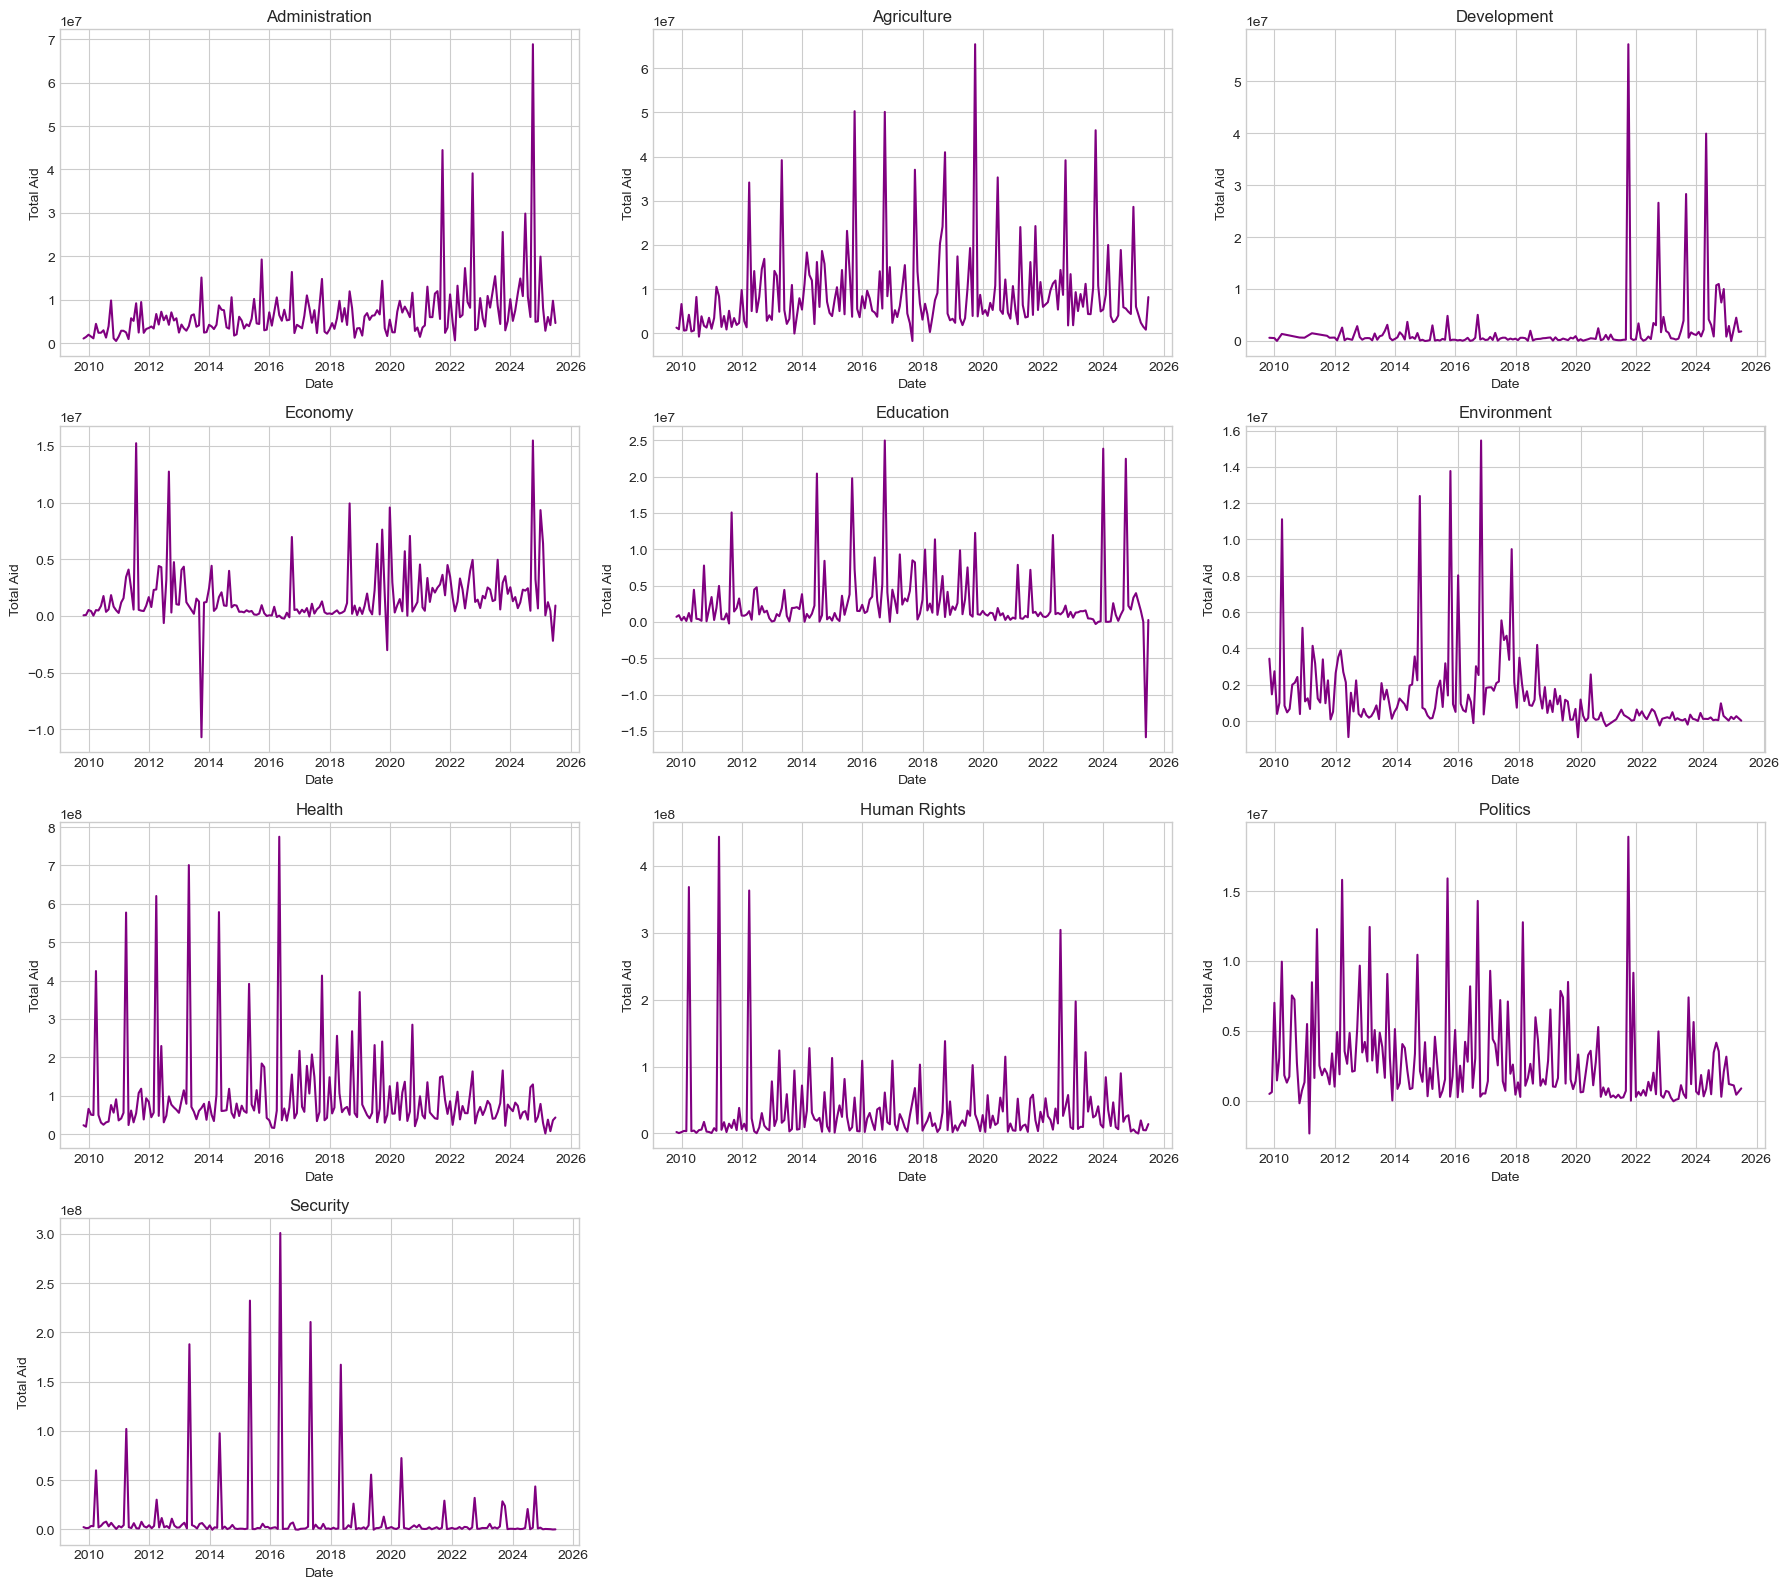

In [ ]:
# Visualize
sectors = sector_ts['us_sector_name'].unique()
n_sectors = len(sectors)

cols = 3
rows = int(np.ceil(n_sectors / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

for i, sector in enumerate(sectors):
    subset = sector_ts[sector_ts['us_sector_name'] == sector]
    axes[i].plot(subset['transaction_date'], subset['total_aid'], color='purple')
    axes[i].set_title(sector)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Total Aid')
    # Rotate date labels for readability
    axes[i].tick_params(axis='x', rotation=0)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
results = []

for sector, df_sector in sector_ts.groupby('us_sector_name'):
    df_sector = df_sector[['transaction_date', 'total_aid']].rename(
        columns={'transaction_date': 'ds', 'total_aid': 'y'}
    )
    df_sector = df_sector.dropna()
    
    if len(df_sector) < 24:
        continue  # skip short series

    train = df_sector.iloc[:-6]  # last 6 months as test
    test = df_sector.iloc[-6:]

    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    forecast = model.predict(test)

    mae = mean_absolute_error(test['y'], forecast['yhat'])
    rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))

    results.append({'sector': sector, 'MAE': mae, 'RMSE': rmse})

results_df = pd.DataFrame(results).sort_values('RMSE')
print(results_df.head(10))

20:24:29 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:30 - cmdstanpy - INFO - Chain [1] done processing
20:24:30 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
20:24:31 - cmdstanpy - INFO - Chain [1] start processing
20:24:31 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1] done processing
20:24:32 - cmdstanpy - INFO - Chain [1] start processing
20:24:32 - cmdstanpy - INFO - Chain [1]

           sector           MAE          RMSE
5     Environment  9.220150e+05  1.266040e+06
8        Politics  1.250363e+06  1.393260e+06
3         Economy  2.328012e+06  2.740519e+06
2     Development  2.660352e+06  2.798956e+06
4       Education  4.687291e+06  8.050019e+06
0  Administration  7.808432e+06  8.574609e+06
1     Agriculture  9.124990e+06  1.081147e+07
9        Security  1.787428e+07  3.480344e+07
7    Human Rights  2.751871e+07  3.919322e+07
6          Health  6.567068e+07  9.402383e+07


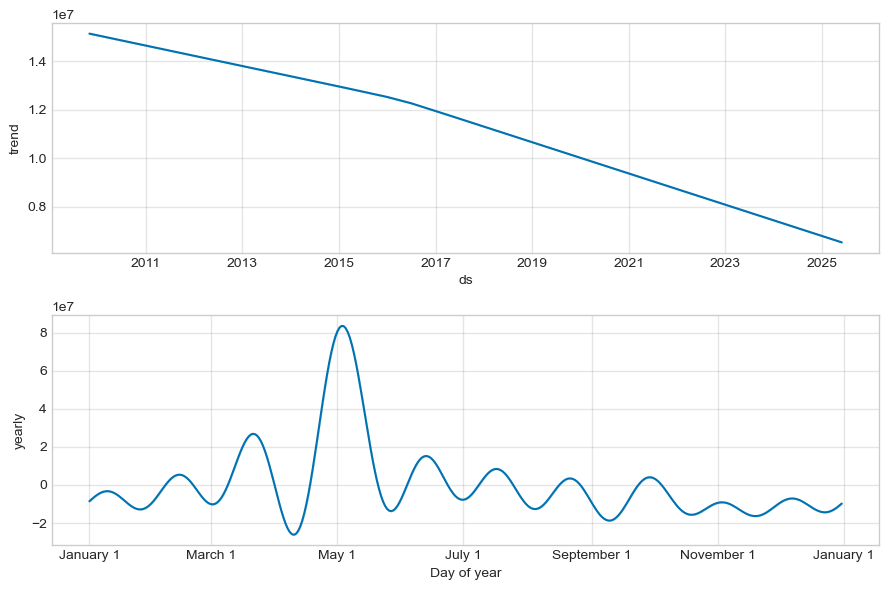

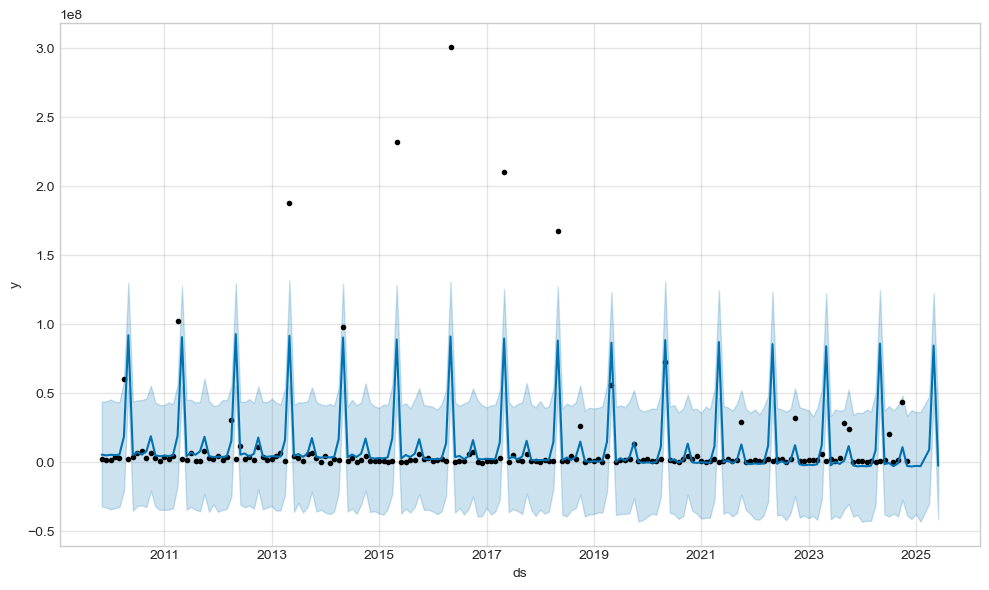

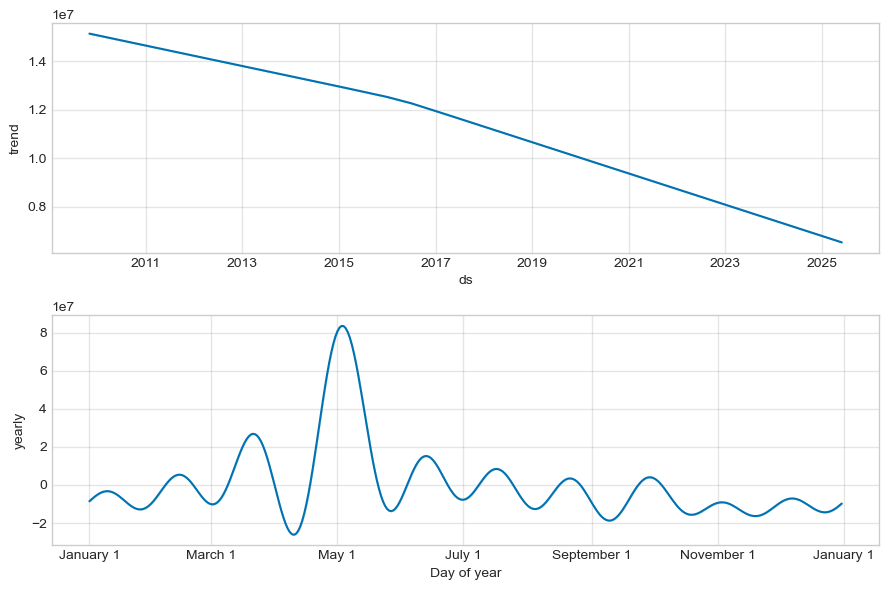

In [98]:
forecast = model.predict(df_sector)
model.plot(forecast)
model.plot_components(forecast)

### AGENCY LEVEL FORECASTING

In [ ]:
# Ensure the date column is datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Aggregate monthly 
agency_ts = (
    df.groupby(['managing_subagency_or_bureau_name', pd.Grouper(key='transaction_date', freq='M')])
      .agg({'constant_dollar_amount': 'sum'})
      .reset_index()
      .rename(columns={'constant_dollar_amount': 'total_aid'})
)

agency_ts

,managing_subagency_or_bureau_name,transaction_date,total_aid
0,Africa,2009-10-31,2720785.0
1,Africa,2009-12-31,2470327.0
2,Africa,2010-10-31,3424318.0
3,Africa,2010-12-31,3247186.0
4,Africa,2011-10-31,2905945.0
...,...,...,...
2541,not applicable,2024-09-30,961838.0
2542,not applicable,2024-10-31,848337.0
2543,not applicable,2024-11-30,100244.0
2544,not applicable,2024-12-31,547362.0


ValueError: ('Lengths must match to compare', (2546,), (66,))

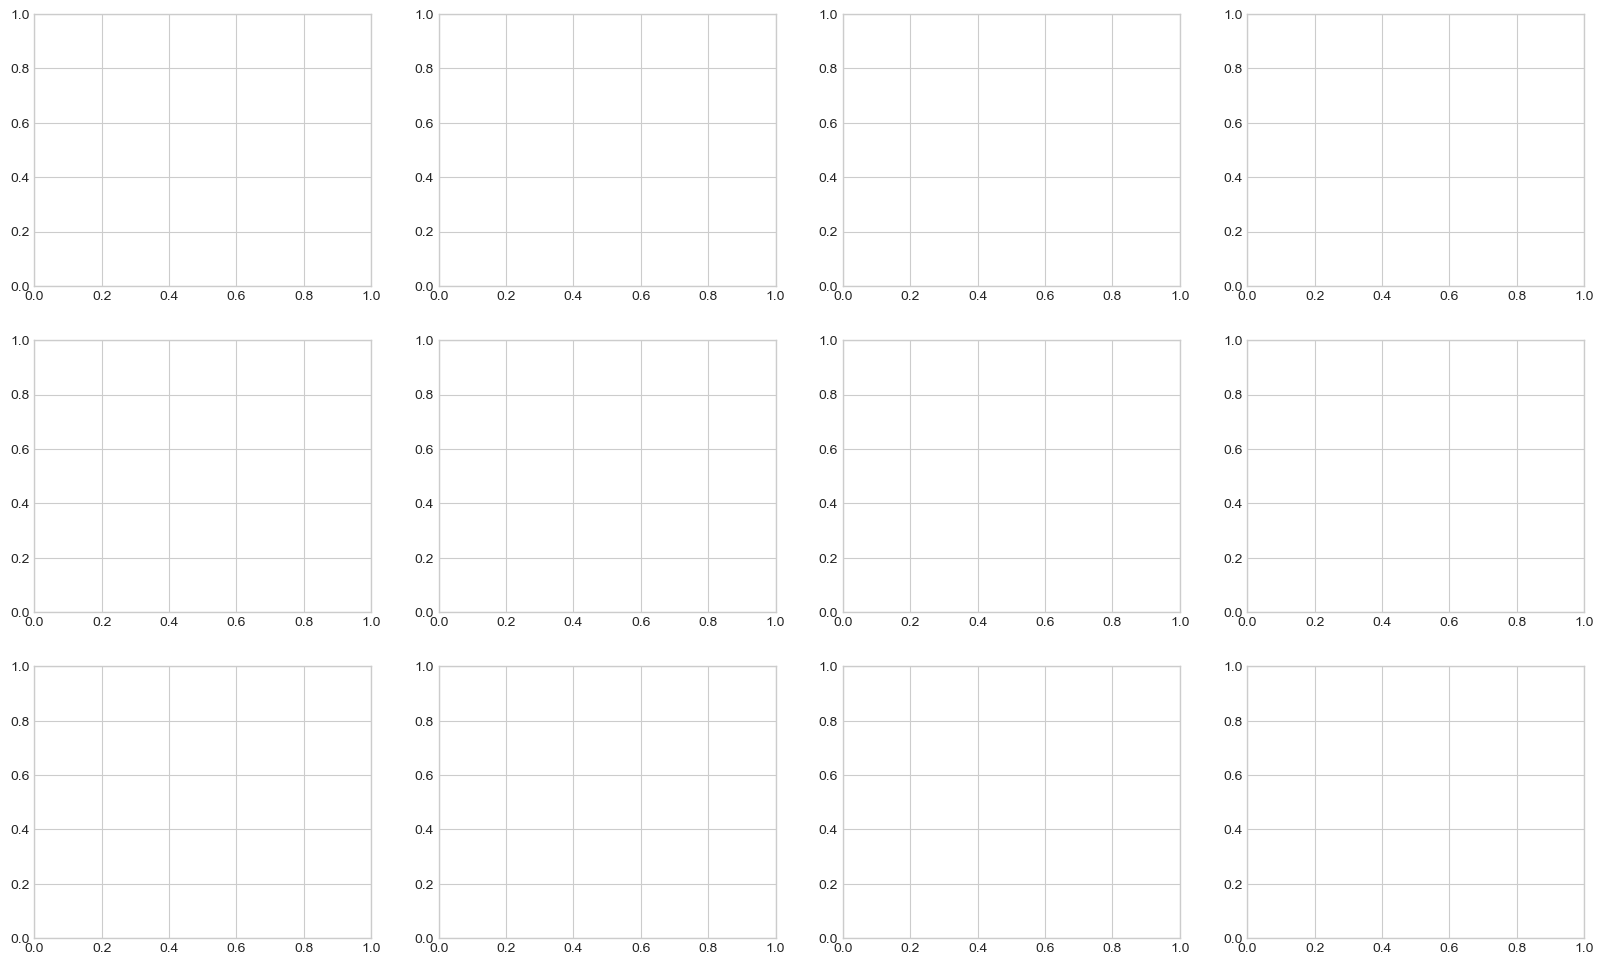

In [113]:
# Visualize
agencies = agency_ts['managing_subagency_or_bureau_name'].unique()
n_agencies = len(agencies)

cols = 4
rows = int(np.ceil(n_sectors / cols))

fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, agency in enumerate(agencies):
    subset = agency_ts[agency_ts['managing_subagency_or_bureau_name'] == agencies]
    axes[i].plot(subset['transaction_date'], subset['total_aid'], color='purple')
    axes[i].set_title(sector)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Total Aid')
    # Rotate date labels for readability
    axes[i].tick_params(axis='x', rotation=0)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()